In [1]:
from gutenbergpy.gutenbergcache import GutenbergCache, GutenbergCacheTypes
import os
import json
import pandas as pd
import numpy as np
import pickle as pkl
import seaborn as sns
import gensim
from gensim.test.utils import common_texts

# load config
with open('config.json', 'r') as f:
    config = json.load(f)
cwd = os.getcwd()
os.chdir(config['REPODIR'])
import Utils as U
from Corpus import Corpus
os.chdir(cwd)

from collections import Counter, defaultdict
import itertools

from gensim.models import KeyedVectors
from gensim.test.utils import datapath

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")
import pickle as pkl
from sklearn.decomposition import PCA
import nltk

/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with open("data_v4.pkl", "rb") as infile:
        data = pkl.load(infile)

# data = U.load_file('data_v2.pkl', 'pkl', config['DATADIR'])

Fetch works for every book

In [3]:
catalog = U.load_file('data_w_subj_new.csv', 'csv', config['DATADIR'])

In [4]:
data_text = [dat['text'] for dat in data]
tokenizer = nltk.RegexpTokenizer(r'\w+')

tokenized_text = [tokenizer.tokenize(' '.join(text)) for text in data_text]
joined_text = [' '.join(text) for text in data_text]

In [5]:
# Worked fine with 'glove-wiki-gigaword-300'

import gensim.downloader
glove_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

In [6]:
for idx, d in enumerate(data):
    d['vectors'] = []
    for token in tokenized_text[idx]:
        try:
            d['vectors'].append(glove_vectors[token])
        except:
            continue
    d['mean_vector'] = np.array([v for v in d['vectors']]).mean(axis = 0)
    if not d['mean_vector'].shape:
        d['mean_vector'] = np.zeros((100,))
    d['key'] = str(d['book_id']) + str(d['text_lines'])
    # d['subject'] = catalog[catalog['book_id'] == d['book_id']].iloc[0, 9]

/var/folders/b1/vw0sn5w90nnccbfn7bskv0jm0000gn/T/ipykernel_31540/2631584463.py:8: RuntimeWarning: Mean of empty slice.
  d['mean_vector'] = np.array([v for v in d['vectors']]).mean(axis = 0)
/Users/stephentoner/miniconda3/envs/si699proj/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [7]:
# mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape and d['subject'] != 'Other'])
mean_vectors = np.array([d['mean_vector'] for d in data if d['mean_vector'].shape])

In [8]:
# ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape and d['subject'] != 'Other']
ids = [idx for idx, d in enumerate(data) if d['mean_vector'].shape]

In [9]:
titles = [data[idx]['title'] for idx in ids]
# subjects = [data[idx]['subject'] for idx in ids]
decade = [int(data[idx]['decade']) for idx in ids]
gender = [1 if data[idx]['gender'] == "F" else 0 for idx in ids]
penname =[1 if data[idx]['penname'] == "Y" else 0 for idx in ids]
pn_gend = [str(penname[idx]) + str(gender[idx]) for idx in ids]

In [13]:
data[69]

{'author_id': 7361,
 'author_name': 'Cather, Wilella',
 'book_id': 64017,
 'gutenbergbookid': 24,
 'title': 'O Pioneers!',
 'text': ['for a king, but destined to be eaten by an enemy of all kings.',
  '',
  'Dick fretted and fumed all that afternoon, and toward dusk ventured',
  'out from his retreat and rode slowly back in the direction of the',
  'British camps, whose exact whereabouts he had to determine. At the',
  "top of a slight rise he saw in the distance the glow of the soldiers'",
  'camp-fire, and making his horse fast to a tree, some distance from the',
  'road, he proceeded carefully on foot toward the sentinel lines and the',
  'British encampment.',
  '',
  'Half way up to the camp he dropped flat on the ground and waited for',
  'the nearest outpost to come to the end of his stretch, exchange a',
  'word with his neighbor, and turn back. Then Dick crawled between the',
  'two while their backs were turned, and was safely inside the lines.',
  'But where was Fritz? And h

In [10]:
two_dim = mean_vectors

In [11]:
# two_dim = PCA(random_state =0).fit_transform(mean_vectors)[:1000,]
two_dim = PCA(random_state =0).fit_transform(mean_vectors)


In [12]:
xPCA = two_dim[:,0]; yPCA = two_dim[:,1]
xPCA.shape

(4623,)

<Axes: >

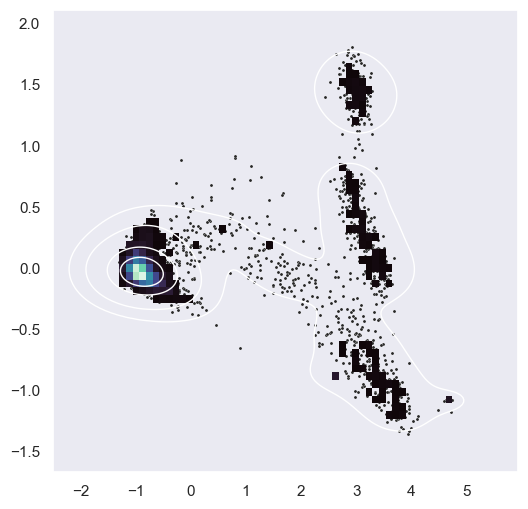

In [13]:
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=xPCA, y=yPCA, s =5, color=".15")
sns.histplot(x=xPCA, y=yPCA, bins=50, pthresh=.1, cmap="mako")
sns.kdeplot(x=xPCA, y=yPCA, levels=5, color="w", linewidths=1)

In [17]:
import plotly.express as px

def pca_scatterplot_3D(model, user_input=None, color_map=None, sentences = None):

    # three_dim = user_input[:,:3]
    three_dim = PCA(random_state=0).fit_transform(user_input)[:,:3]

    df = pd.DataFrame(three_dim)
    df['Label'] = color_map
    df['sentence'] = sentences

    plot_figure = px.scatter_3d(df, x = 0, y = 1, z = 2, color = 'Label', hover_name = 'sentence', size_max = 2)

    plot_figure.show()

In [15]:

# For use in the famous literature set
# decade_gender = [int(str(decade[idx]) + str(gender[idx])) for idx in ids]

In [16]:
tokenized_text[17386]

IndexError: list index out of range

In [28]:
# pca_scatterplot_3D(data, user_input = two_dim, color_map = [str(c) for c in clusters], sentences = titles)
pca_scatterplot_3D(data, user_input = two_dim, color_map = pn_gend, sentences = titles)

In [18]:
from sklearn import mixture

gmm = mixture.BayesianGaussianMixture(n_components=4, covariance_type="full").fit(two_dim)

In [22]:
clusters = gmm.predict(mean_vectors)

In [29]:
extract_data = []

for i, idx in enumerate(ids):
    data[idx]['cluster'] = str(clusters[i])
    extract_data.append(data[idx].copy())



In [32]:
t = pd.DataFrame(extract_data).groupby(by = ['cluster', 'gender']).agg('count')

In [33]:
ed = pd.DataFrame(extract_data)

In [37]:
# ed[ed['cluster'] == 3].unique()

AttributeError: 'DataFrame' object has no attribute 'unique'

In [38]:
t['key'].unstack(0).divide(sum(t['key']))

cluster,0,1,2,3
gender,,,,
F,0.004110,0.008652,0.338957,NaN
M,0.020333,0.040450,0.585118,0.002379
